Sube el dataset etiquetado (ej: dataset_etiquetado_v2.csv)


Saving dataset_etiquetado_v2.csv to dataset_etiquetado_v2.csv

=== Distribución general de etiquetas ===
{np.int64(0): np.int64(1490), np.int64(1): np.int64(1795)}
Proporción fraude: 0.5464

Distribución y_train: [1192 1436]
Distribución y_test : [298 359]

=== Mejor umbral (por F1 en TEST) ===
threshold    0.450000
precision    0.877095
recall       0.874652
f1           0.875872
Name: 40, dtype: float64

=== Métricas globales (en TEST) usando el umbral óptimo ===
Threshold: 0.45
Precision: 0.8771
Recall   : 0.8747
F1-score : 0.8759
ROC-AUC  : 0.9452
PR-AUC   : 0.9610

=== Classification report (umbral óptimo) ===
              precision    recall  f1-score   support

           0     0.8495    0.8523    0.8509       298
           1     0.8771    0.8747    0.8759       359

    accuracy                         0.8645       657
   macro avg     0.8633    0.8635    0.8634       657
weighted avg     0.8646    0.8645    0.8646       657

=== Matriz de confusión (umbral óptimo) ===
[[254 

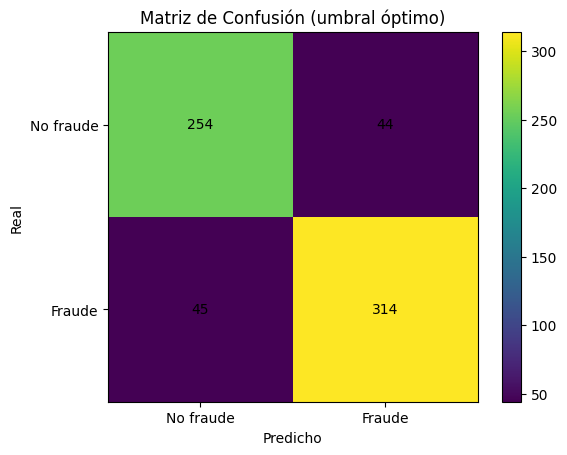

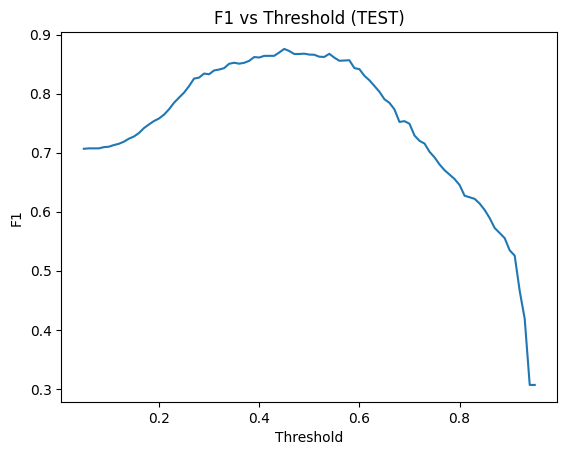


=== MODO PRUEBA ===
Escribe un mensaje y el modelo dirá si parece fraude.
Comandos: 'salir' para terminar | 'umbral=0.30' para cambiar umbral

Predicción: NO FRAUDE
Probabilidad estimada de fraude: 0.4245
Umbral usado: 0.45
Referencia (TEST): F1 global (FRAUDE) ~ 0.8759 (ver classification_report para clase NO FRAUDE)
------------------------------------------------------------
Predicción: FRAUDE
Probabilidad estimada de fraude: 0.5301
Umbral usado: 0.45
Referencia (TEST): Precision de FRAUDE ~ 0.8771 | Recall de FRAUDE ~ 0.8747 | F1 ~ 0.8759
------------------------------------------------------------
Predicción: FRAUDE
Probabilidad estimada de fraude: 0.7083
Umbral usado: 0.45
Referencia (TEST): Precision de FRAUDE ~ 0.8771 | Recall de FRAUDE ~ 0.8747 | F1 ~ 0.8759
------------------------------------------------------------
Predicción: FRAUDE
Probabilidad estimada de fraude: 0.7083
Umbral usado: 0.45
Referencia (TEST): Precision de FRAUDE ~ 0.8771 | Recall de FRAUDE ~ 0.8747 | F1 ~

In [ ]:
# ==========================================================
# ENTRENAR + PROBAR MODELO (Google Colab)
# Dataset: dataset_etiquetado_v2.csv (o el que subas)
# Modelo: TF-IDF (word n-grams) + Logistic Regression
# Incluye:
#   - Split estratificado train/test
#   - Métricas (precision, recall, f1, ROC-AUC, PR-AUC)
#   - Matriz de confusión (con el mejor umbral por F1)
#   - Ajuste fino de umbral (threshold tuning)
#   - Modo prueba: ingresar mensajes y predecir fraude
#
# Nota: En un mensaje nuevo no existe "ground truth", por lo que NO se puede
# dar "precisión real" del caso individual. Se reporta:
#   - Probabilidad estimada del modelo (score)
#   - Decisión (fraude/no fraude) con el umbral seleccionado
#   - Métricas globales del modelo (en test) como referencia
# ==========================================================

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
    roc_auc_score,
    average_precision_score
)

import matplotlib.pyplot as plt

from google.colab import files

# -----------------------------
# 0) Subir dataset etiquetado
# -----------------------------
print("Sube el dataset etiquetado (ej: dataset_etiquetado_v2.csv)")
uploaded = files.upload()
data_path = list(uploaded.keys())[0]

df = pd.read_csv(data_path)

TEXT_COL = "Mensaje"
LABEL_COL = "fraud_label"

if TEXT_COL not in df.columns or LABEL_COL not in df.columns:
    raise ValueError(f"Se requieren columnas '{TEXT_COL}' y '{LABEL_COL}'. Columnas: {list(df.columns)}")

df[TEXT_COL] = df[TEXT_COL].fillna("").astype(str)
df[LABEL_COL] = df[LABEL_COL].astype(int)

X = df[TEXT_COL].values
y = df[LABEL_COL].values

print("\n=== Distribución general de etiquetas ===")
unique, counts = np.unique(y, return_counts=True)
print(dict(zip(unique, counts)))
print("Proporción fraude:", round(y.mean(), 4))

# -----------------------------
# 1) Split estratificado
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("\nDistribución y_train:", np.bincount(y_train))
print("Distribución y_test :", np.bincount(y_test))

# -----------------------------
# 2) Pipeline TF-IDF + Logistic Regression
#    Ajustes recomendados para texto social:
#      - word ngrams (1,2)
#      - sublinear_tf
#      - class_weight para desbalance
# -----------------------------
pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        analyzer="word",
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.95,
        sublinear_tf=True
    )),
    ("clf", LogisticRegression(
        max_iter=3000,
        class_weight="balanced",
        solver="liblinear"
    ))
])

pipe.fit(X_train, y_train)

# -----------------------------
# 3) Probabilidades en TEST
# -----------------------------
y_proba_test = pipe.predict_proba(X_test)[:, 1]

# -----------------------------
# 4) Ajuste fino del umbral (maximizar F1 en TEST)
# -----------------------------
def evaluate_threshold(y_true, y_proba, thr):
    y_pred = (y_proba >= thr).astype(int)
    p, r, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )
    return p, r, f1, y_pred

thresholds = np.arange(0.05, 0.96, 0.01)

scores = []
for thr in thresholds:
    p, r, f1, _ = evaluate_threshold(y_test, y_proba_test, thr)
    scores.append((thr, p, r, f1))

scores_df = pd.DataFrame(scores, columns=["threshold", "precision", "recall", "f1"])
best = scores_df.loc[scores_df["f1"].idxmax()]
best_thr = float(best["threshold"])

best_p, best_r, best_f1, y_pred_best = evaluate_threshold(y_test, y_proba_test, best_thr)

roc_auc = roc_auc_score(y_test, y_proba_test) if len(np.unique(y_test)) > 1 else np.nan
pr_auc  = average_precision_score(y_test, y_proba_test) if len(np.unique(y_test)) > 1 else np.nan
cm = confusion_matrix(y_test, y_pred_best)

print("\n=== Mejor umbral (por F1 en TEST) ===")
print(best)

print("\n=== Métricas globales (en TEST) usando el umbral óptimo ===")
print(f"Threshold: {best_thr:.2f}")
print(f"Precision: {best_p:.4f}")
print(f"Recall   : {best_r:.4f}")
print(f"F1-score : {best_f1:.4f}")
print(f"ROC-AUC  : {roc_auc:.4f}")
print(f"PR-AUC   : {pr_auc:.4f}")

print("\n=== Classification report (umbral óptimo) ===")
print(classification_report(y_test, y_pred_best, digits=4, zero_division=0))

print("=== Matriz de confusión (umbral óptimo) ===")
print(cm)

# -----------------------------
# 5) Gráficas: Matriz de confusión + F1 vs threshold
# -----------------------------
plt.figure()
plt.imshow(cm, interpolation="nearest")
plt.title("Matriz de Confusión (umbral óptimo)")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.xticks([0, 1], ["No fraude", "Fraude"])
plt.yticks([0, 1], ["No fraude", "Fraude"])

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")
plt.colorbar()
plt.show()

plt.figure()
plt.plot(scores_df["threshold"], scores_df["f1"])
plt.title("F1 vs Threshold (TEST)")
plt.xlabel("Threshold")
plt.ylabel("F1")
plt.show()

# -----------------------------
# 6) Modo prueba: ingresar mensajes y predecir
# -----------------------------
def predict_message(msg: str, threshold: float = best_thr):
    msg = "" if msg is None else str(msg)
    proba = float(pipe.predict_proba([msg])[0, 1])
    pred = int(proba >= threshold)
    return proba, pred

print("\n=== MODO PRUEBA ===")
print("Escribe un mensaje y el modelo dirá si parece fraude.")
print("Comandos: 'salir' para terminar | 'umbral=0.30' para cambiar umbral\n")

current_thr = best_thr

while True:
    user_msg = input("Mensaje: ").strip()
    if user_msg.lower() in ["salir", "exit", "quit", "q"]:
        print("Finalizado.")
        break

    # Permitir cambiar umbral en caliente
    if user_msg.lower().startswith("umbral="):
        try:
            new_thr = float(user_msg.split("=", 1)[1])
            if not (0.0 <= new_thr <= 1.0):
                raise ValueError
            current_thr = new_thr
            print(f"Umbral actualizado a: {current_thr:.2f}")
        except Exception:
            print("Formato inválido. Usa: umbral=0.30")
        print("-" * 60)
        continue

    proba, pred = predict_message(user_msg, current_thr)
    etiqueta = "FRAUDE" if pred == 1 else "NO FRAUDE"

    print(f"Predicción: {etiqueta}")
    print(f"Probabilidad estimada de fraude: {proba:.4f}")
    print(f"Umbral usado: {current_thr:.2f}")

    # Referencia de desempeño global (no del caso individual)
    if pred == 1:
        print(f"Referencia (TEST): Precision de FRAUDE ~ {best_p:.4f} | Recall de FRAUDE ~ {best_r:.4f} | F1 ~ {best_f1:.4f}")
    else:
        print(f"Referencia (TEST): F1 global (FRAUDE) ~ {best_f1:.4f} (ver classification_report para clase NO FRAUDE)")

    print("-" * 60)

# -----------------------------
# 7) (Opcional) Interpretabilidad: top n-grams que empujan a fraude/no fraude
# -----------------------------
tfidf = pipe.named_steps["tfidf"]
clf = pipe.named_steps["clf"]

feature_names = np.array(tfidf.get_feature_names_out())
coefs = clf.coef_.ravel()

top_pos = np.argsort(coefs)[-25:][::-1]  # más asociados a fraude
top_neg = np.argsort(coefs)[:25]         # más asociados a no fraude

print("\n=== Top n-grams asociados a FRAUDE (coef +) ===")
for idx in top_pos:
    print(f"{feature_names[idx]:<30} {coefs[idx]:.4f}")

print("\n=== Top n-grams asociados a NO FRAUDE (coef -) ===")
for idx in top_neg:
    print(f"{feature_names[idx]:<30} {coefs[idx]:.4f}")
